In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gseapy import enrichr

Get rid of XY genes and lower number of genes
remove low variance genes and remove outliers
z score normalization

median absolute deviation
add more components to the MDS

In [2]:
# Expression matrix: rows are patients, columns are genes
expression = pd.read_csv("TCGA.STAD.expression.txt", sep="\t")
expression.set_index(["patient_id"], inplace=True)
expression = expression.drop("sample_id", axis=1)
expression = expression.fillna(0)

# Metadata: patient annotations
metadata = pd.read_csv("TCGA.STAD.metadata.txt", sep="\t")
metadata.set_index("patient_id", inplace=True)

# Mutation matrix (optional for this analysis, can be used for additional insights)
mutations = pd.read_csv("TCGA.STAD.mutations.txt", sep="\t")

# Use some normalization and filtering

In [3]:
expression_scaled = np.log2(expression + 2)

gene_sums = expression_scaled.sum(axis=0)
mask = gene_sums > 200
col_indices = np.where(mask)[0]
expression_filtered = expression_scaled.iloc[:, col_indices]

gene_sums = expression_filtered.var(axis=0)
mask = gene_sums > 0.7
col_indices = np.where(mask)[0]
expression_filtered = expression_filtered.iloc[:, col_indices]
scaler = StandardScaler()
expression_scaled = scaler.fit_transform(expression_filtered)

# scaler = MinMaxScaler(feature_range=(0, 1))
# expression_scaled = scaler.fit_transform(expression_filtered)

In [7]:
# PCA
pca = PCA(n_components=20) 
pca_result = pca.fit_transform(expression_scaled)
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance: {explained_variance}")

# MDS
mds = MDS(n_components=20, random_state=42)
mds_result = mds.fit_transform(expression_scaled)

# t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(expression_scaled)

# UMAP
# umap_model = umap.UMAP(n_neighbors=18, min_dist=0.5, n_components=8, metric='wminkowski', random_state=42)
umap_model = umap.UMAP(min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
umap_result = umap_model.fit_transform(expression_scaled)

PCA Explained Variance: [0.16724516 0.06579619 0.05182129 0.04497745 0.03119    0.03095508
 0.02752773 0.02341944 0.01879677 0.01802553 0.01474469 0.01343525
 0.01088955 0.01029549 0.01008371 0.00938813 0.00789201 0.00759129
 0.00738558 0.00617227]


/tscc/nfs/home/s5xu/mambaforge/envs/singlecell/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tscc/nfs/home/s5xu/mambaforge/envs/singlecell/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Take a look at Silhouette from KMean on the dimension reduction values

In [8]:
results = pd.DataFrame({
    "PCA_1": pca_result[:, 0], "PCA_2": pca_result[:, 1],
    "MDS_1": mds_result[:, 0], "MDS_2": mds_result[:, 1],
    "TSNE_1": tsne_result[:, 0], "TSNE_2": tsne_result[:, 1],
    "UMAP_1": umap_result[:, 0], "UMAP_2": umap_result[:, 1],
}, index=expression.index)
results = results.join(metadata, how="inner")

# Kmean
for dimension in [("PCA", pca_result), ('MDS', mds_result),('TSNE', tsne_result),('UMAP', umap_result)]:
    input_result = dimension[1]
    name = dimension[0]
    for i in range(2, 8):
        cluster = i
        kmeans = KMeans(n_clusters=cluster, random_state=42)
        cluster_labels = kmeans.fit_predict(input_result)
        results[f"{name}_{str(i)}_cluster"] = cluster_labels
        sil_score = silhouette_score(input_result, cluster_labels)
        print(f"Silhouette Score for K-means {name} (k={cluster}): {sil_score:.3f}")

Silhouette Score for K-means PCA (k=2): 0.167
Silhouette Score for K-means PCA (k=3): 0.138
Silhouette Score for K-means PCA (k=4): 0.116
Silhouette Score for K-means PCA (k=5): 0.122
Silhouette Score for K-means PCA (k=6): 0.117
Silhouette Score for K-means PCA (k=7): 0.133
Silhouette Score for K-means MDS (k=2): 0.108
Silhouette Score for K-means MDS (k=3): 0.079
Silhouette Score for K-means MDS (k=4): 0.082
Silhouette Score for K-means MDS (k=5): 0.092
Silhouette Score for K-means MDS (k=6): 0.083
Silhouette Score for K-means MDS (k=7): 0.090
Silhouette Score for K-means TSNE (k=2): 0.271
Silhouette Score for K-means TSNE (k=3): 0.236
Silhouette Score for K-means TSNE (k=4): 0.276
Silhouette Score for K-means TSNE (k=5): 0.262
Silhouette Score for K-means TSNE (k=6): 0.306
Silhouette Score for K-means TSNE (k=7): 0.308
Silhouette Score for K-means UMAP (k=2): 0.777
Silhouette Score for K-means UMAP (k=3): 0.396
Silhouette Score for K-means UMAP (k=4): 0.436
Silhouette Score for K-me

# Silhouette on the metadata labels

In [9]:
for dimension in [("PCA", pca_result), ('MDS', mds_result),('TSNE', tsne_result),('UMAP', umap_result)]:
    input_result = dimension[1]
    name = dimension[0]
    column_name = f"{name}_cluster"
    for metric in metadata.columns[1:-1]:
        if pd.api.types.is_numeric_dtype(results[metric]):
            results[metric] = results[metric].fillna(0)
        else:
            continue
        sil_score = silhouette_score(input_result, results[metric])
        print(f"Silhouette Score for {name} {metric}: {sil_score:.3f}")

Silhouette Score for PCA age_at_initial_pathologic_diagnosis: -0.296
Silhouette Score for PCA OS: 0.002
Silhouette Score for PCA OS.time: -0.235
Silhouette Score for PCA DSS: -0.003
Silhouette Score for PCA DSS.time: -0.235
Silhouette Score for PCA DFI: 0.012
Silhouette Score for PCA DFI.time: -0.310
Silhouette Score for PCA PFI: 0.002
Silhouette Score for PCA PFI.time: -0.228
Silhouette Score for MDS age_at_initial_pathologic_diagnosis: -0.237
Silhouette Score for MDS OS: 0.001
Silhouette Score for MDS OS.time: -0.180
Silhouette Score for MDS DSS: 0.001
Silhouette Score for MDS DSS.time: -0.180
Silhouette Score for MDS DFI: 0.005
Silhouette Score for MDS DFI.time: -0.239
Silhouette Score for MDS PFI: 0.003
Silhouette Score for MDS PFI.time: -0.175
Silhouette Score for TSNE age_at_initial_pathologic_diagnosis: -0.501
Silhouette Score for TSNE OS: 0.005
Silhouette Score for TSNE OS.time: -0.345
Silhouette Score for TSNE DSS: -0.007
Silhouette Score for TSNE DSS.time: -0.345
Silhouette S

# Loop through each parameters to find the best parameters: n_neighbors=18, min_dist=0.5, n_components=8, metric='wminkowski', but clustering seems didn't work

In [265]:
# for i in ['euclidean', 'chebyshev', 'wminkowski']:
#     # UMAP
#     print(i)
#     umap_model = umap.UMAP(n_neighbors=18, min_dist=0.5, n_components=8, metric=i, random_state=42)
#     umap_result = umap_model.fit_transform(expression_scaled)

#     results = pd.DataFrame({
#         "UMAP_1": umap_result[:, 0], "UMAP_2": umap_result[:, 1],
#     }, index=expression.index)
#     results = results.join(metadata, how="inner")

#     for dimension in [('UMAP', umap_result)]:
#         input_result = dimension[1]
#         name = dimension[0]
#         for metric in metadata.columns[1:-1]:
#             if pd.api.types.is_numeric_dtype(results[metric]):
#                 results[metric] = results[metric].fillna(0)
#             else:
#                 continue
#             sil_score = silhouette_score(input_result, results[metric])
#             print(f"Silhouette Score for {i} {name} {metric}: {sil_score:.3f}")

# Look at cluster by UMAP and metadata label

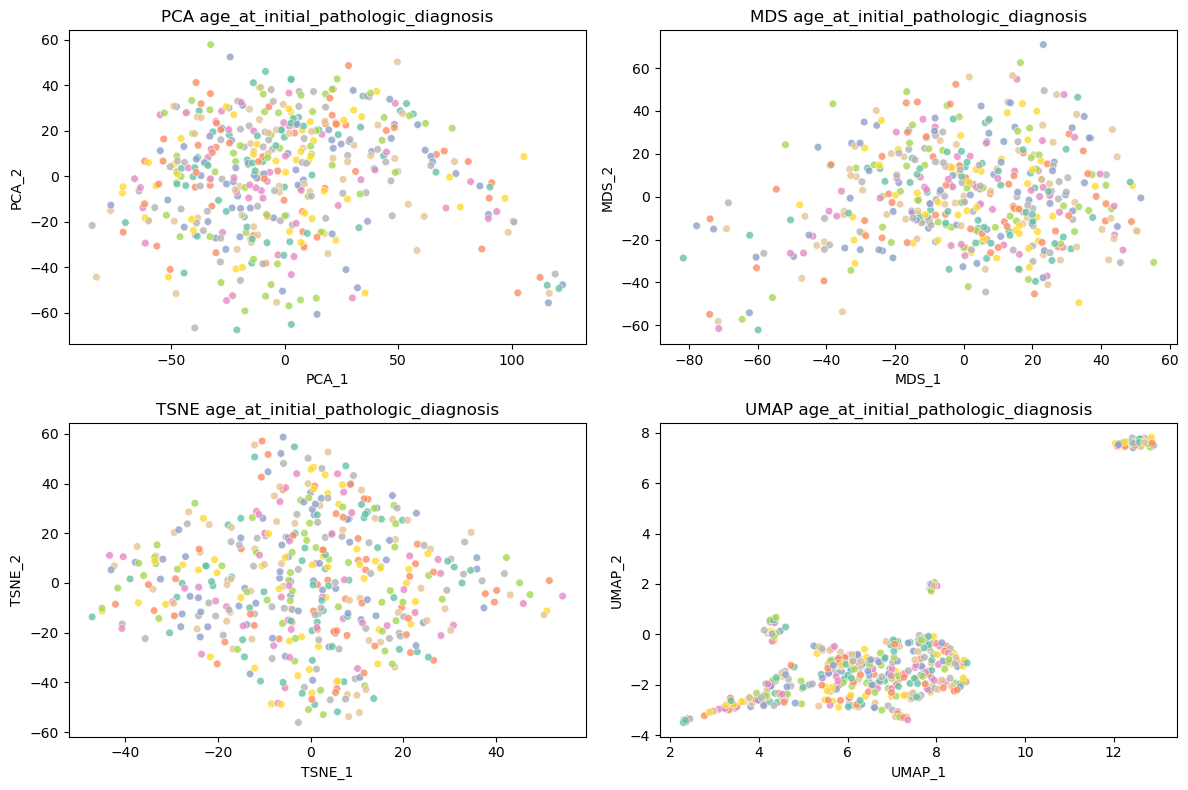

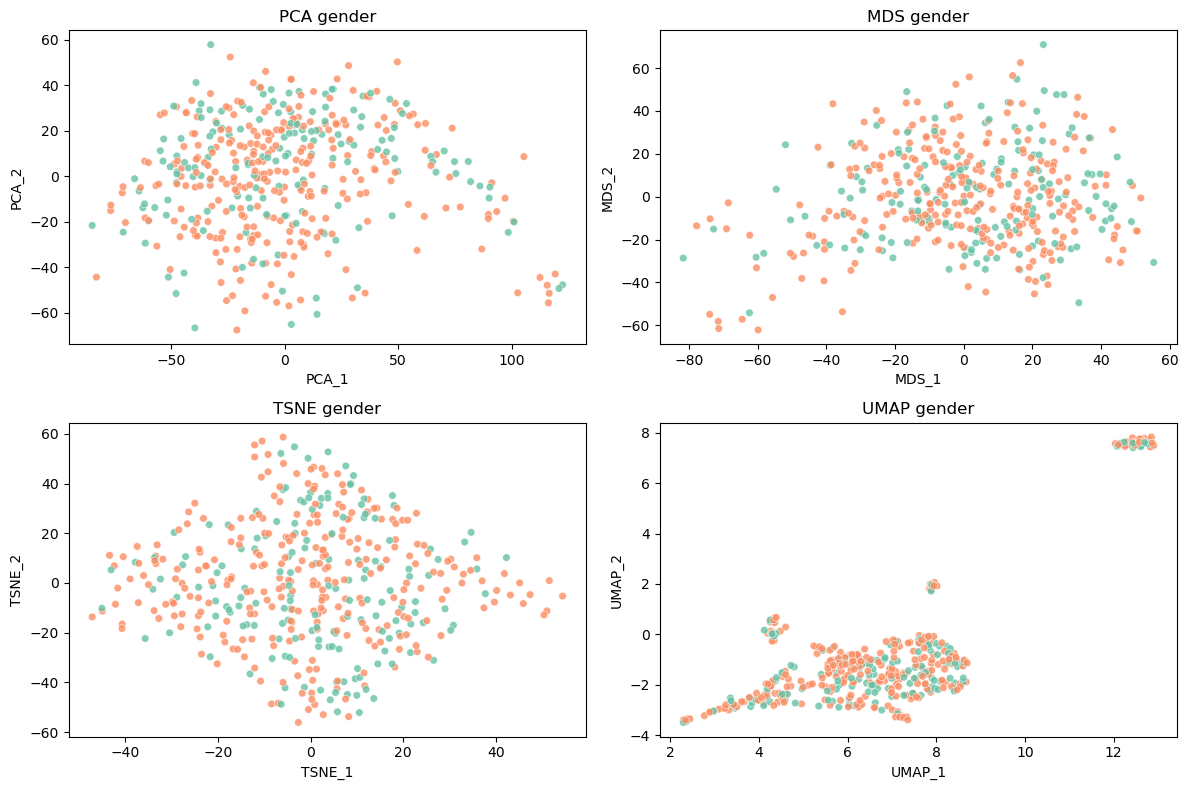

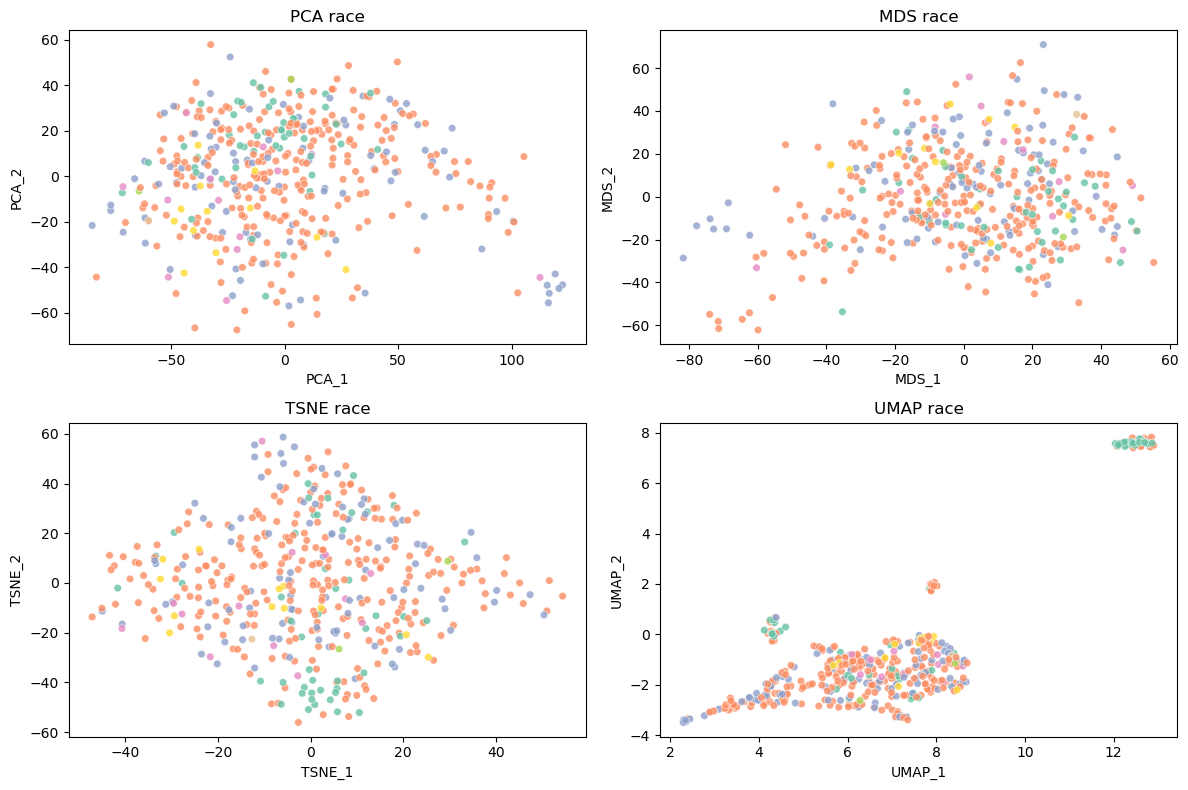

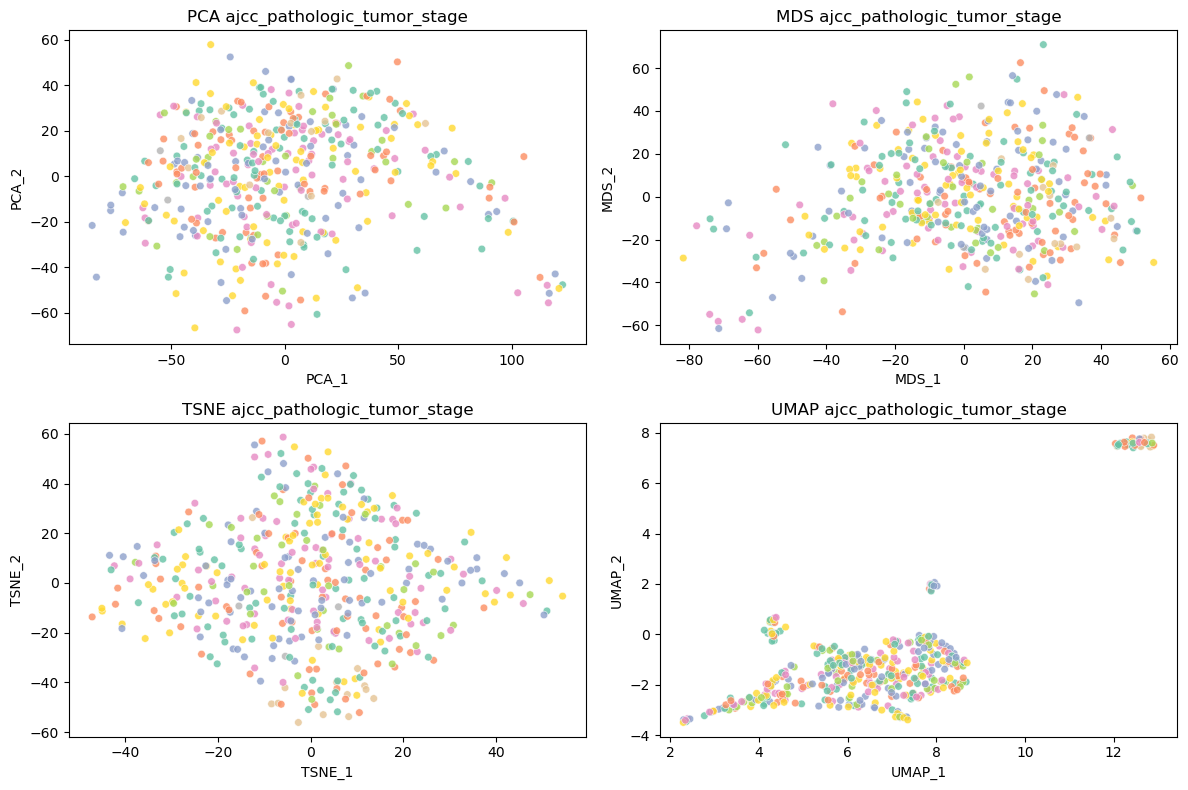

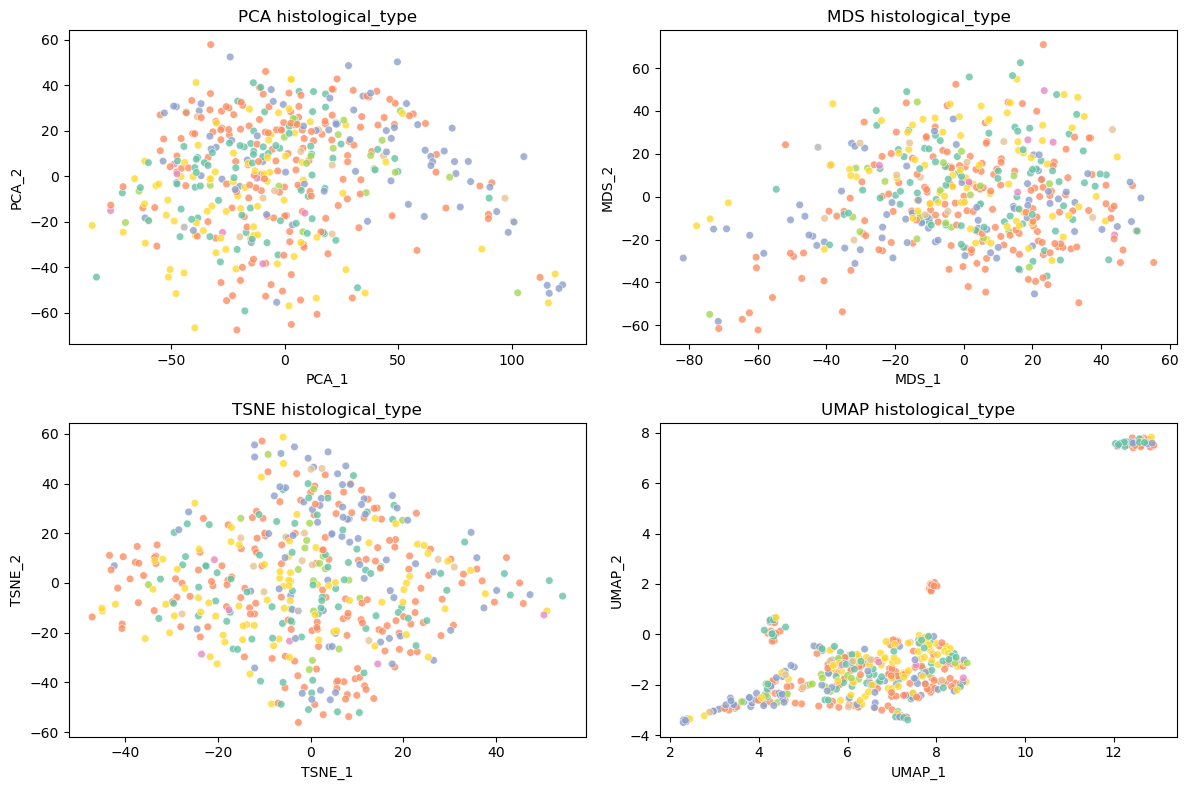

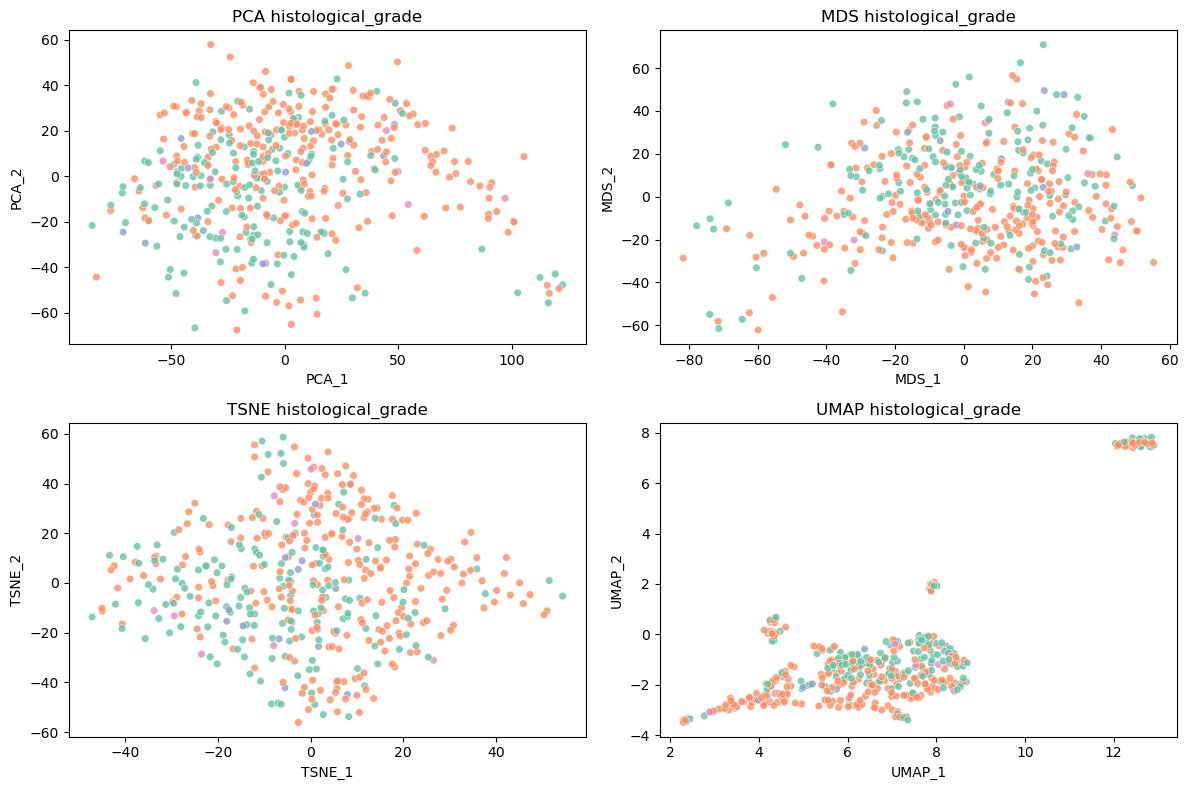

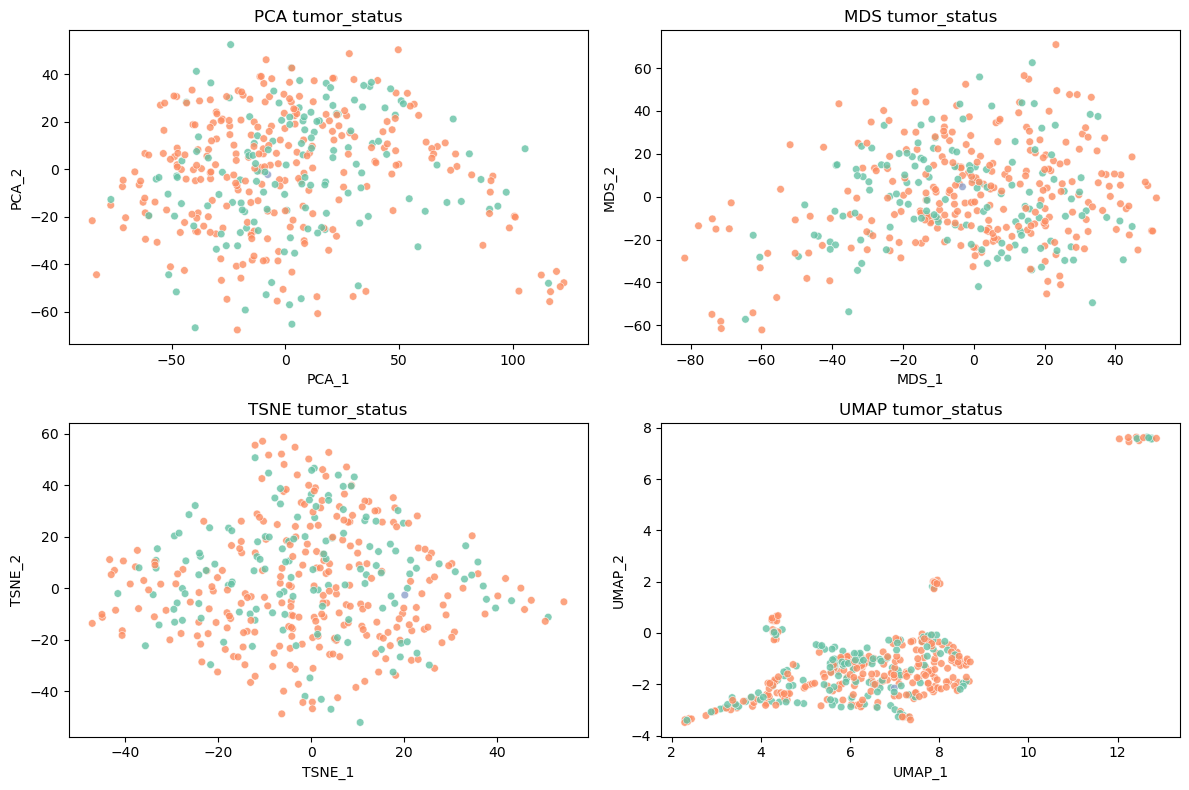

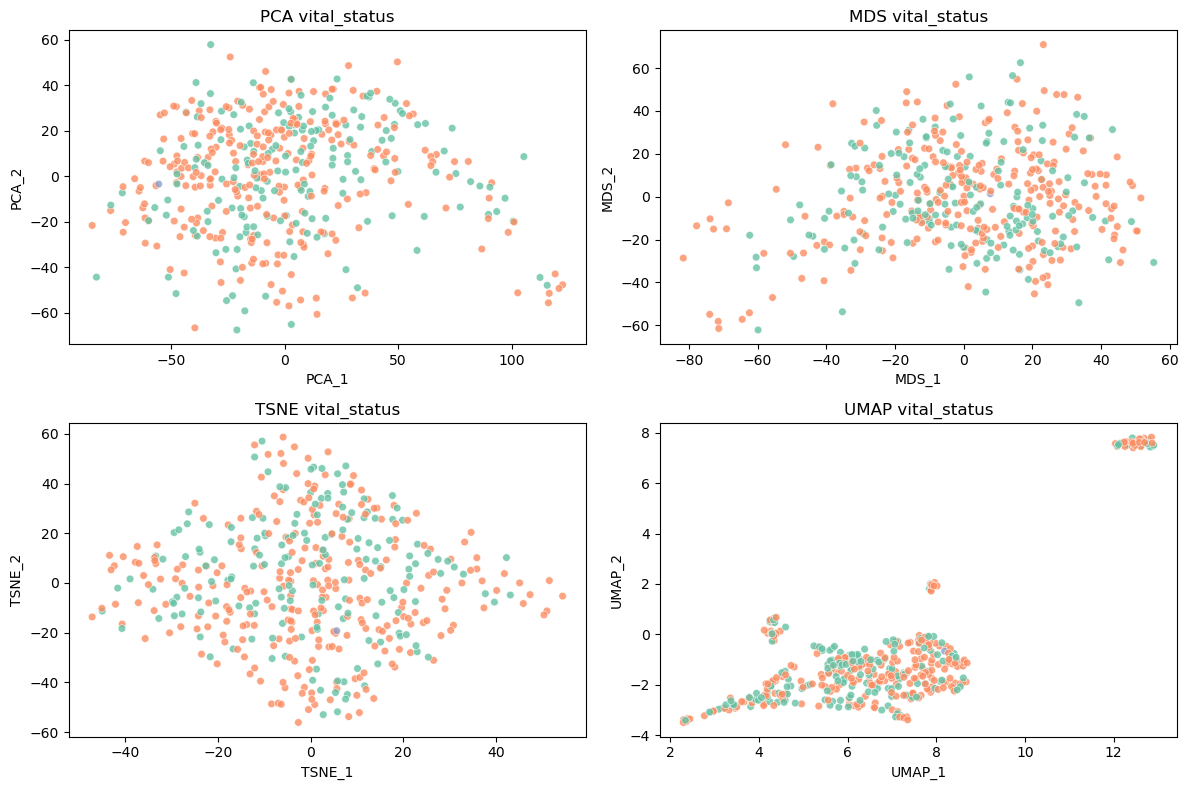

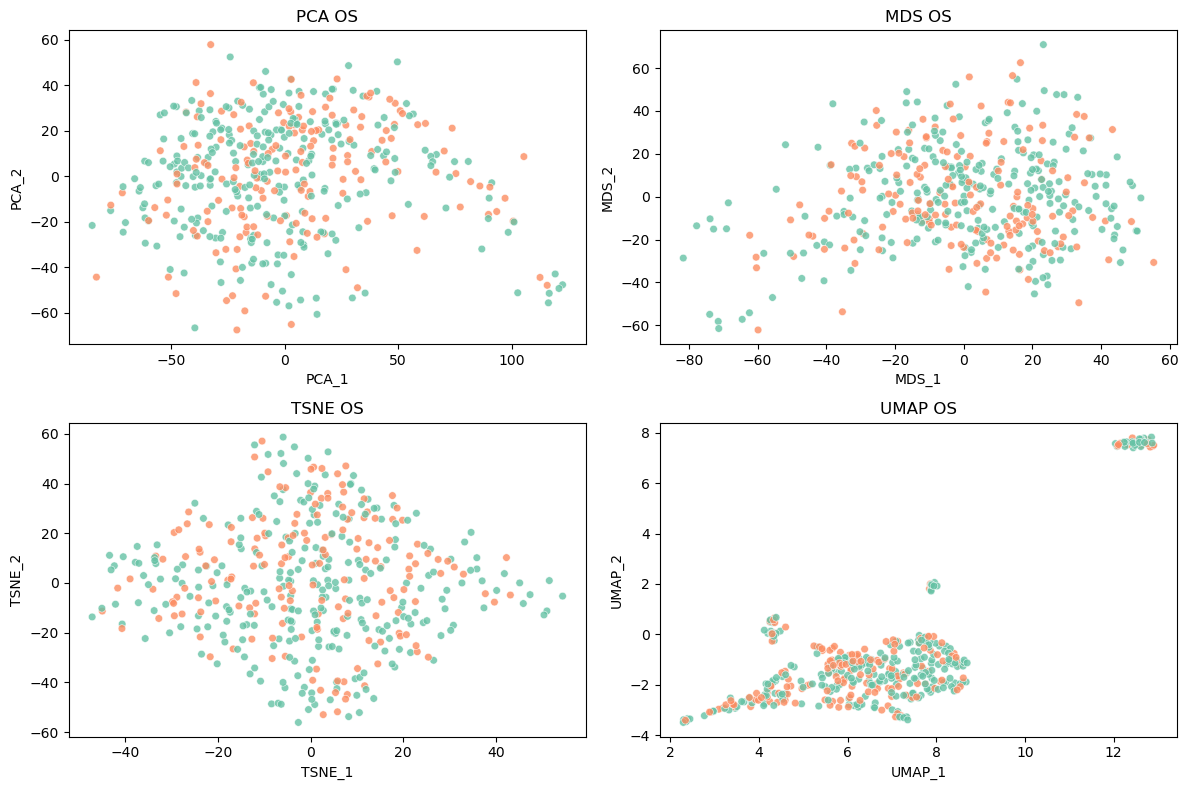

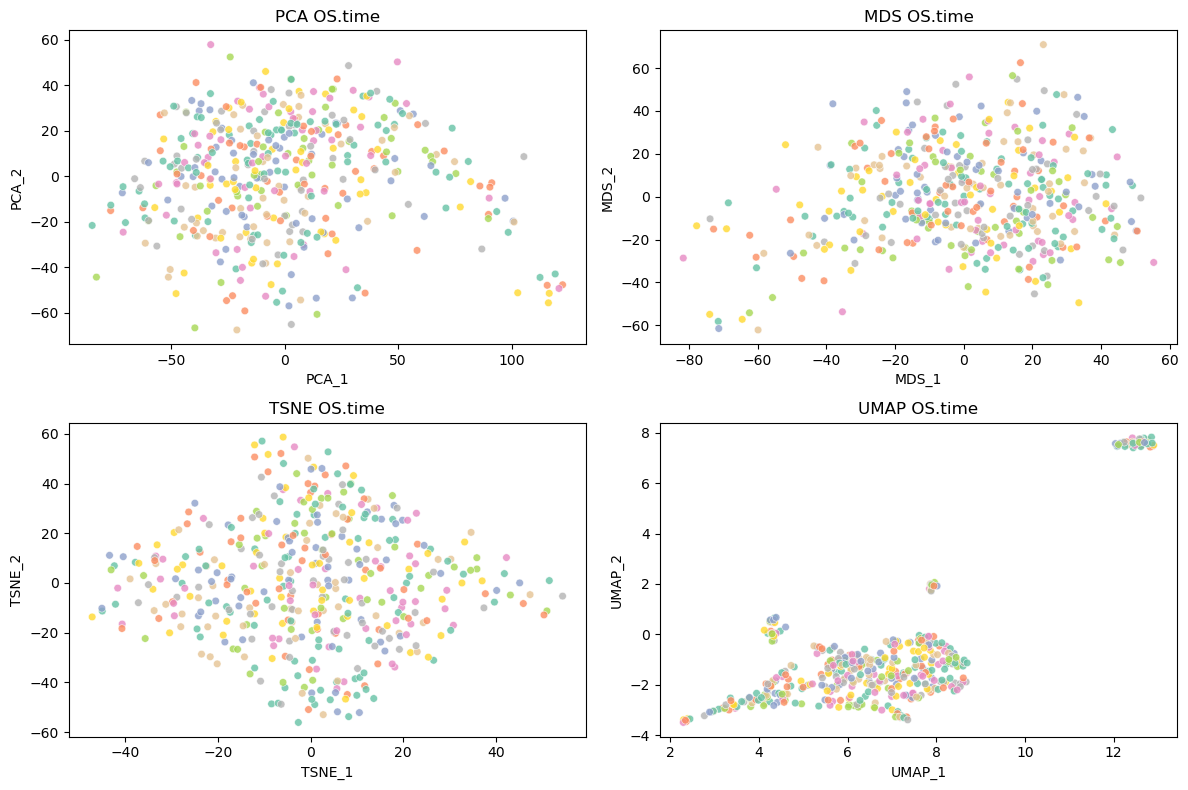

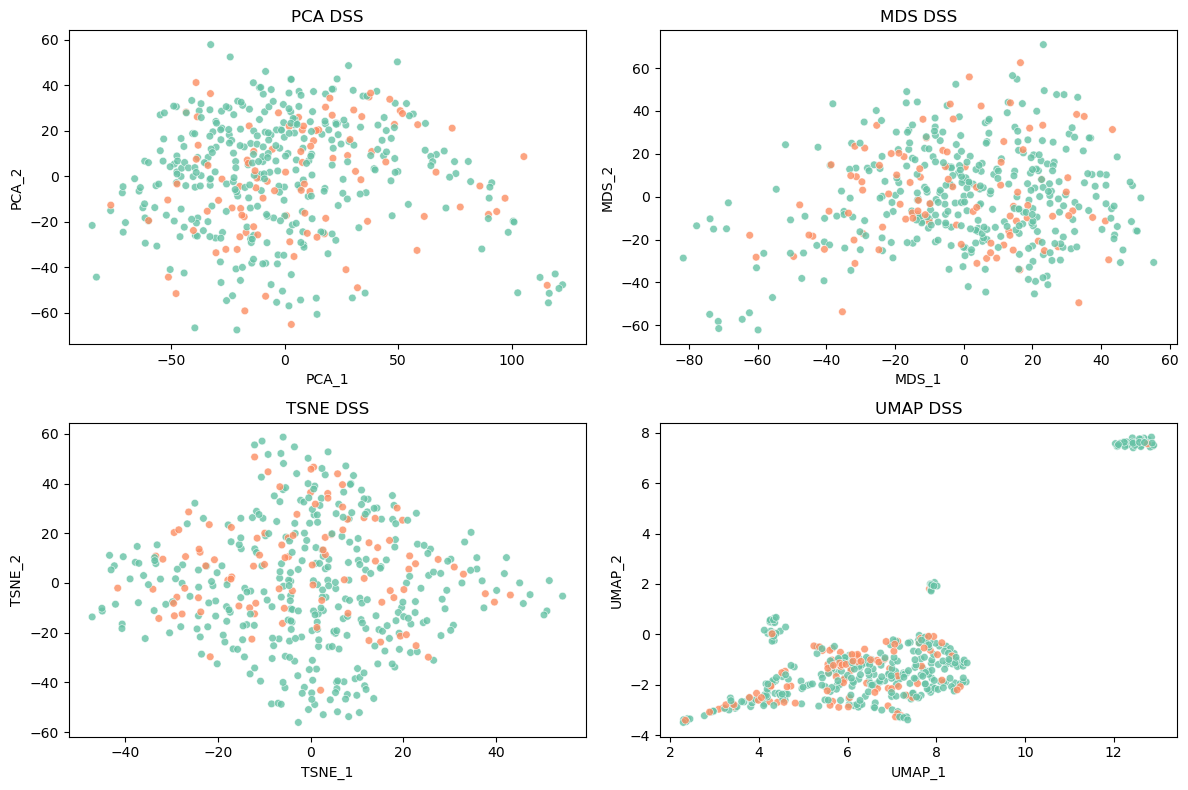

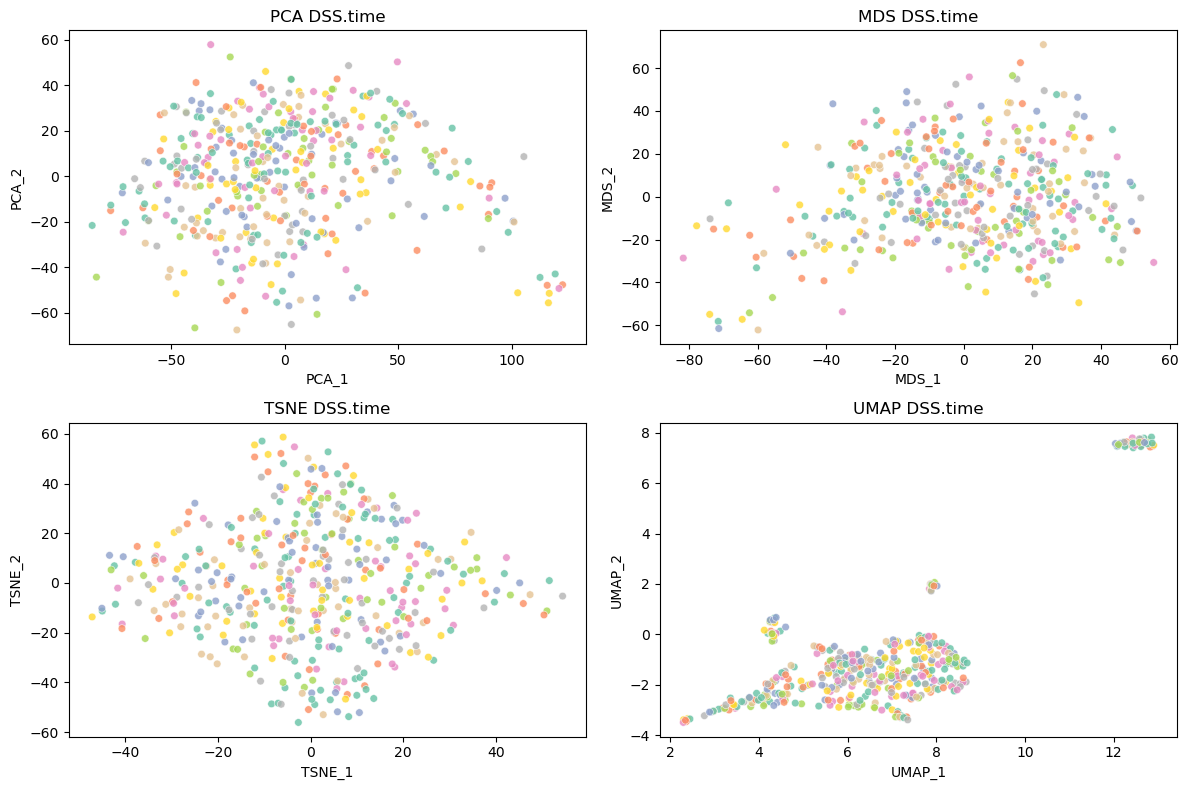

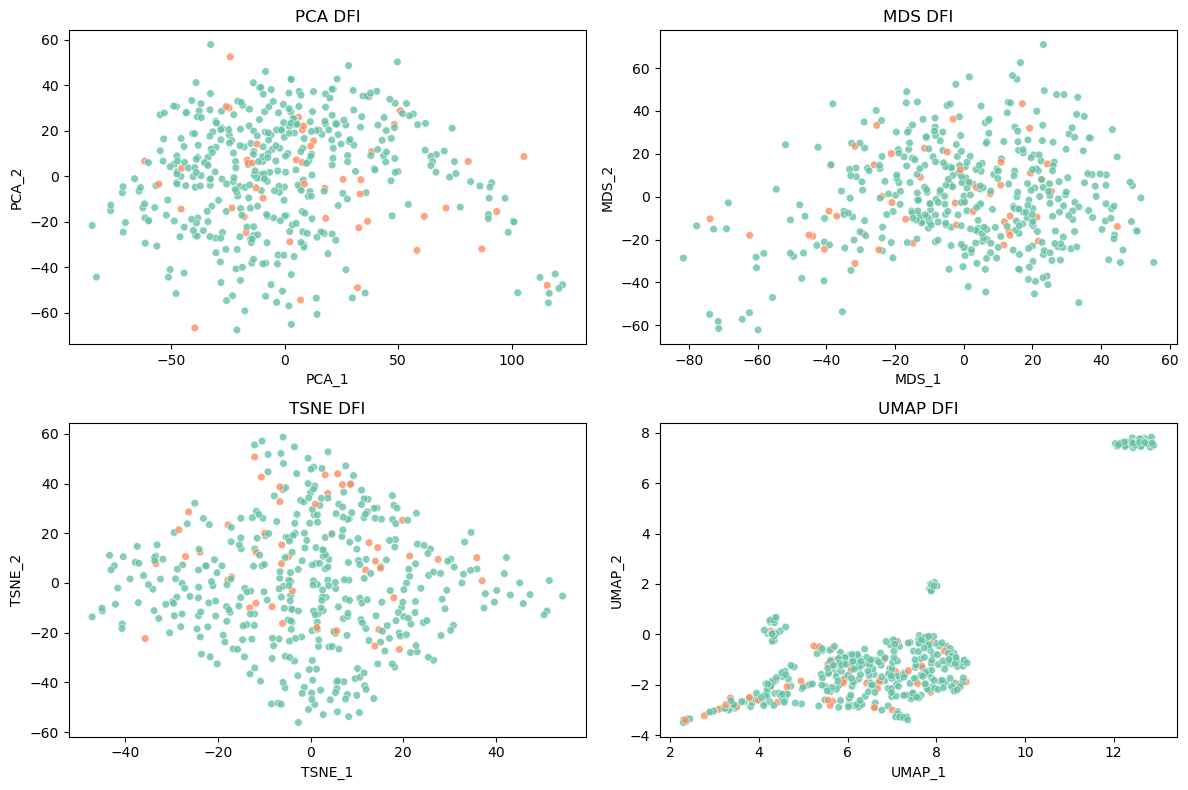

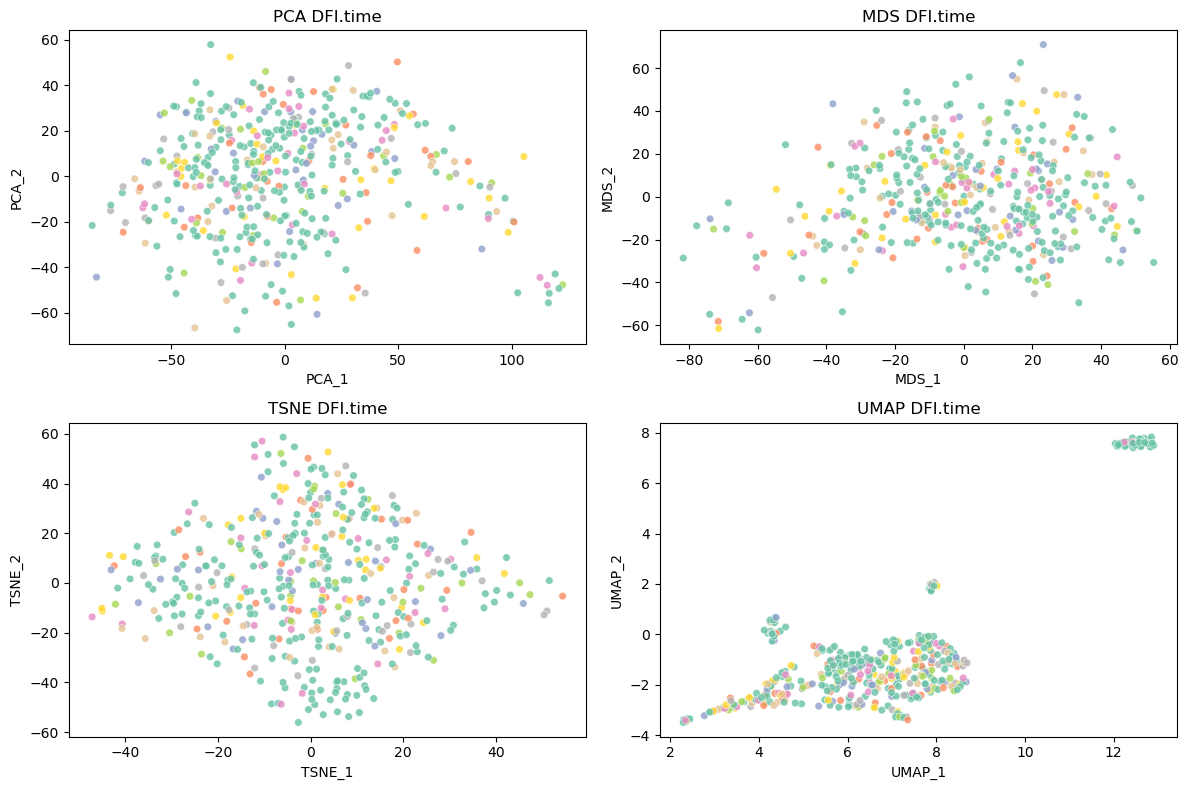

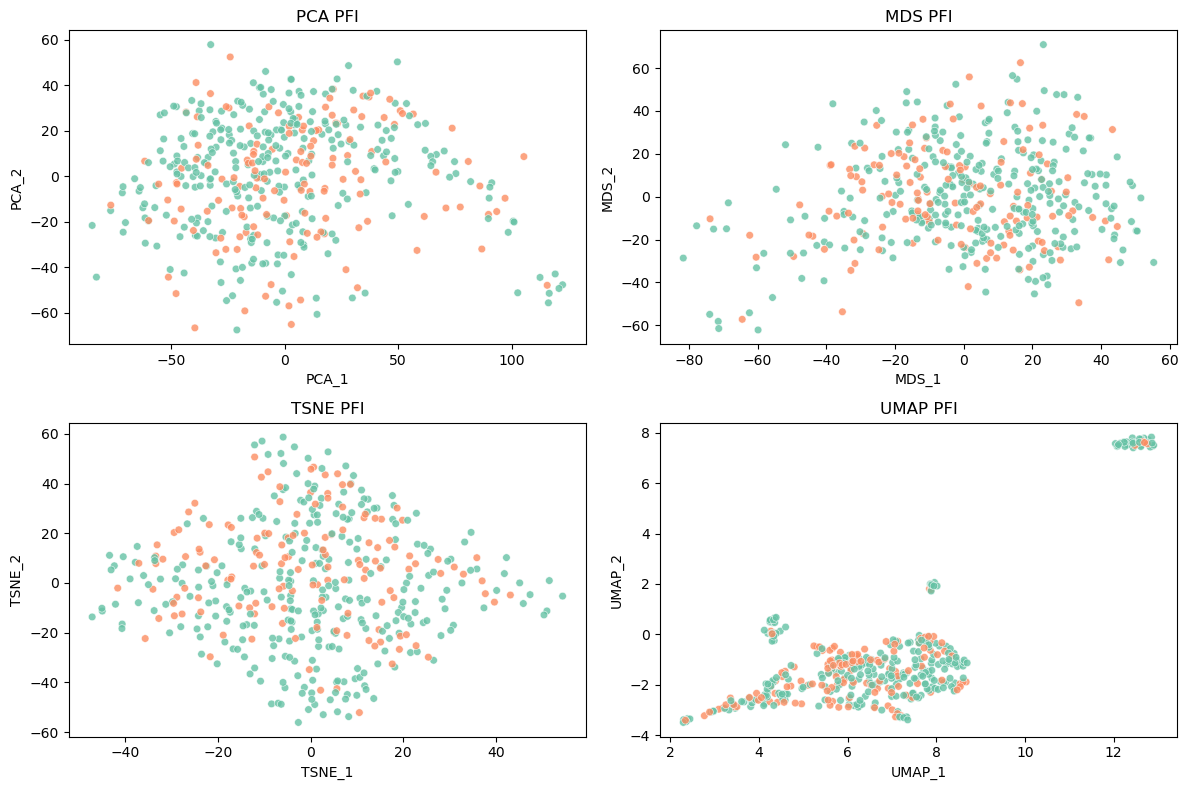

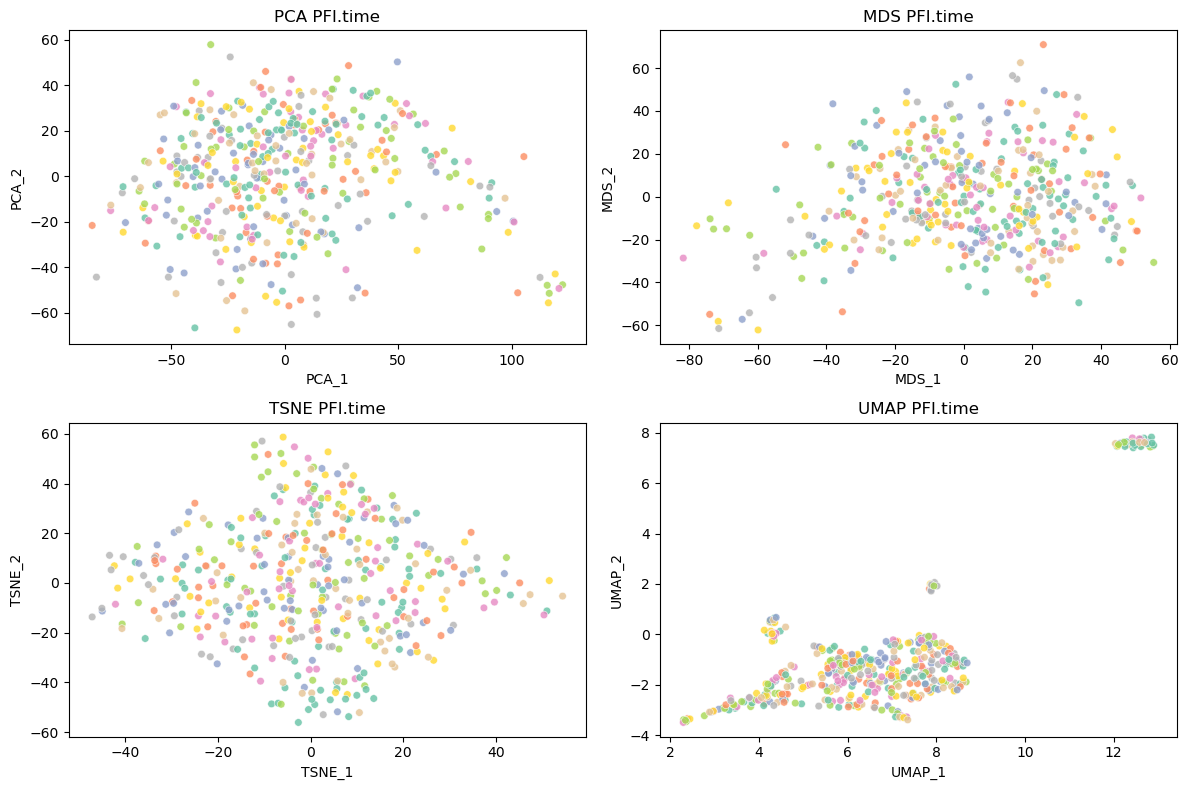

In [26]:
methods = ['PCA', 'MDS', 'TSNE', 'UMAP']

k = 4

for metric in metadata.columns[1:-1]:
    plt.figure(figsize=(12, 8))
    for i, method in enumerate(methods):
        plt.subplot(2, 2, i+1)
        x_col = method.upper() + '_1'
        y_col = method.upper() + '_2'
        cluster_col = f'{method}_{k}_cluster'

        sns.scatterplot(
            data=results, 
            x=x_col, 
            y=y_col, 
            hue=metric, 
            palette='Set2', 
            s=30, 
            alpha=0.8,
            legend=False
        )
        plt.title(f"{method.upper()} {metric}")
        plt.xlabel(x_col)
        plt.ylabel(y_col)

    plt.tight_layout()
    plt.show()

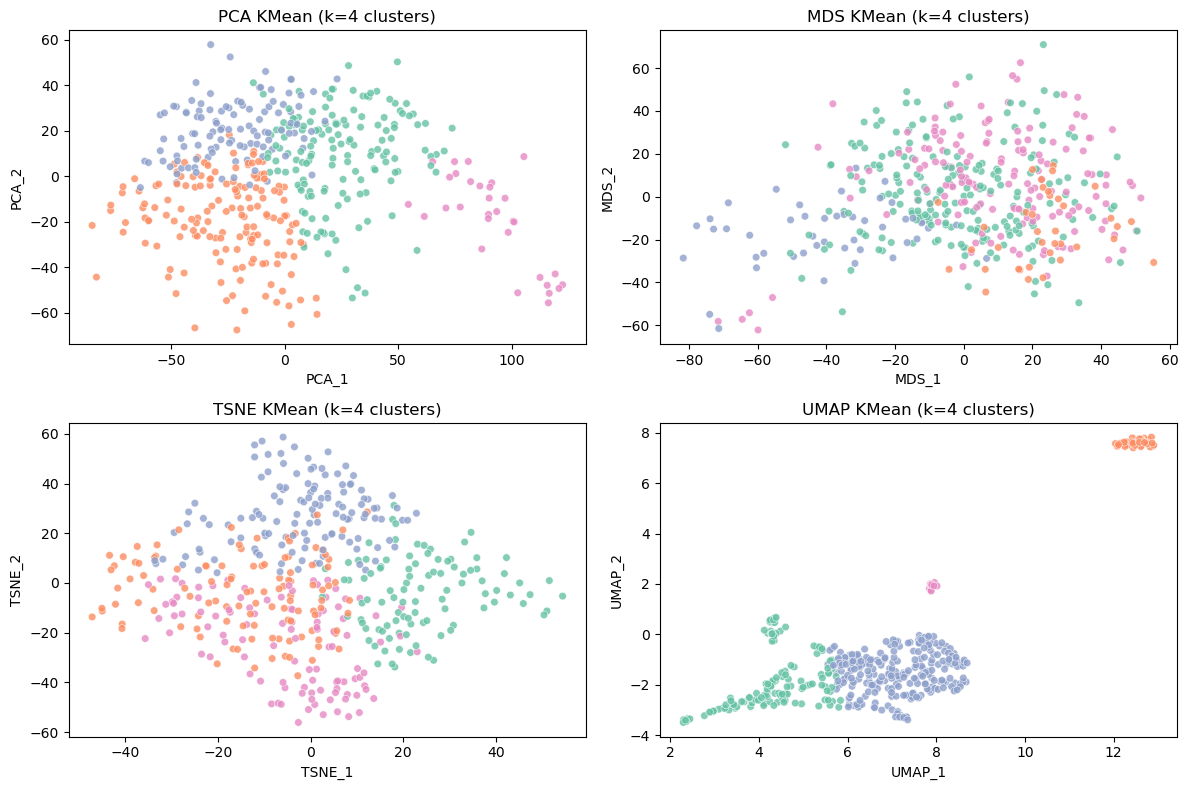

In [29]:
methods = ['PCA', 'MDS', 'TSNE', 'UMAP']

k = 4

# for metric in metadata.columns[1:-1]:

plt.figure(figsize=(12, 8))
for i, method in enumerate(methods):
    plt.subplot(2, 2, i+1)
    x_col = method.upper() + '_1'
    y_col = method.upper() + '_2'
    cluster_col = f'{method}_{k}_cluster'

    sns.scatterplot(
        data=results, 
        x=x_col, 
        y=y_col, 
        hue=cluster_col, 
        palette='Set2', 
        s=30, 
        alpha=0.8,
        legend=False
    )
    plt.title(f"{method.upper()} KMean (k={k} clusters)")
    plt.xlabel(x_col)
    plt.ylabel(y_col)

plt.tight_layout()
plt.show()

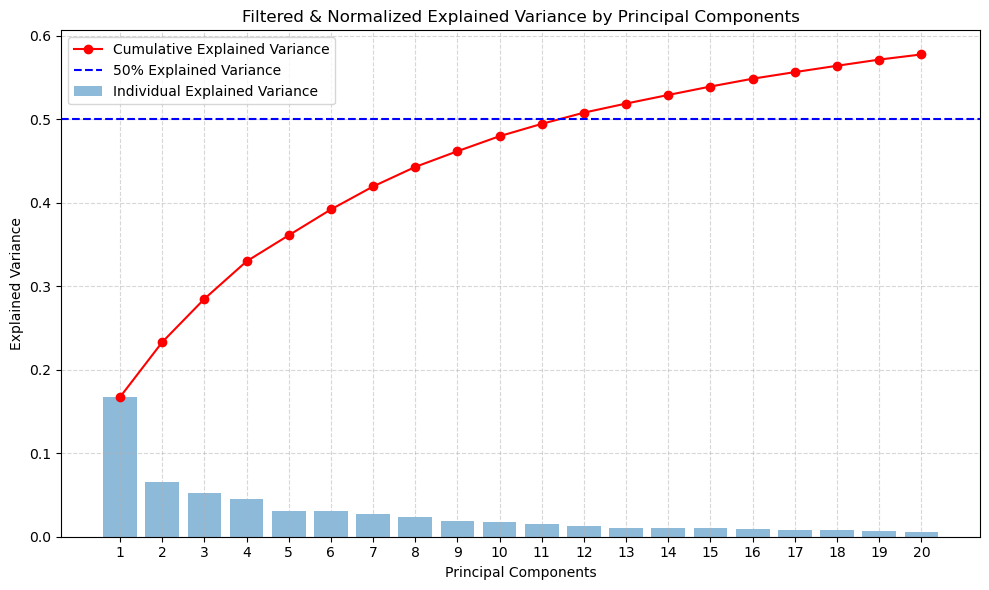

In [15]:
cumulative_variance = np.cumsum(explained_variance)

threshold = 0.5

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='red', label='Cumulative Explained Variance')
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='Individual Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Filtered & Normalized Explained Variance by Principal Components')
plt.xticks(np.arange(1, len(explained_variance)+1, step=1))
plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=1.5, label='50% Explained Variance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

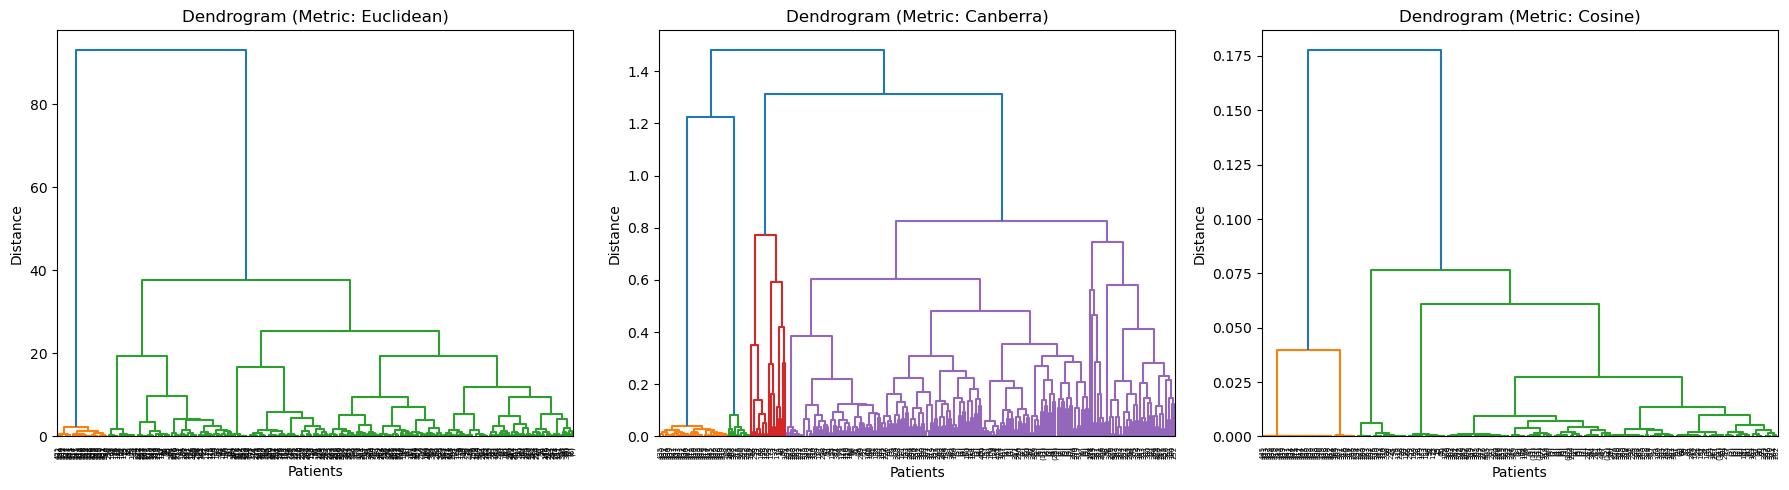

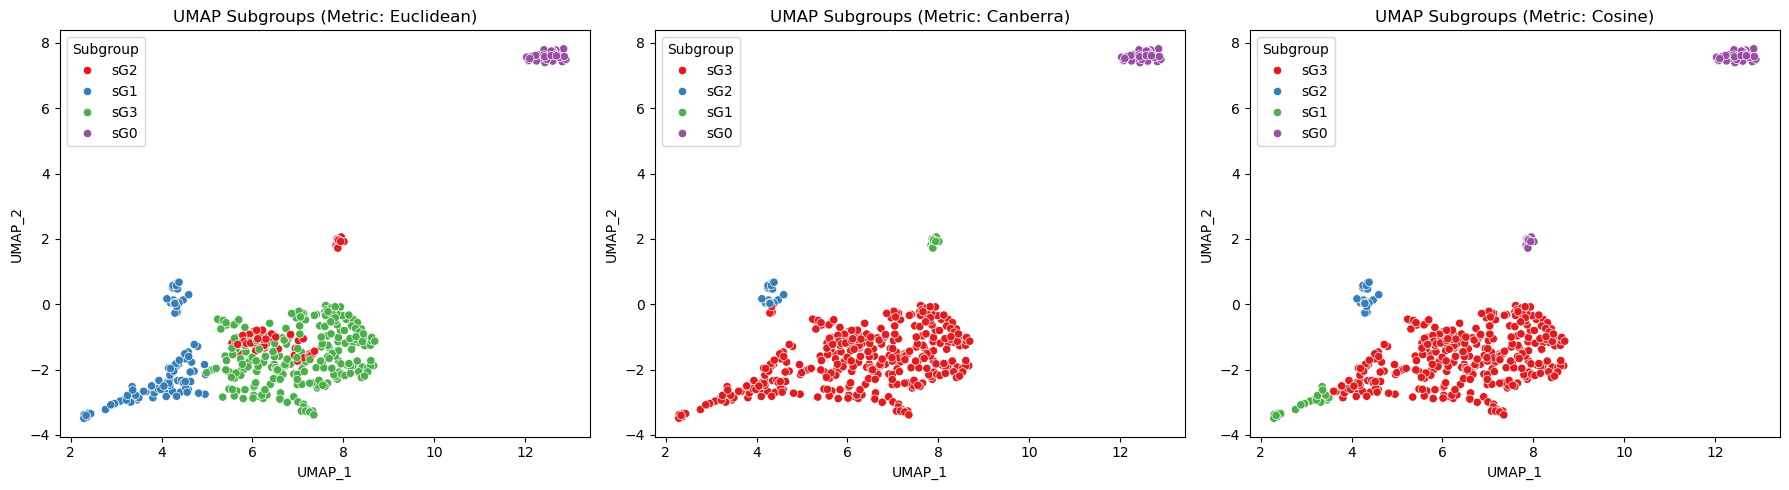

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

distance_metrics = ["euclidean", "canberra", "cosine"]
linkages = {}
subgroups = {}

for metric in distance_metrics:
    method = "ward" if metric == "euclidean" else "average"
    Z = linkage(umap_result, method=method, metric=metric)
    linkages[metric] = Z
    labels = fcluster(Z, t=4, criterion="maxclust")
    subgroups[metric] = labels

for metric in distance_metrics:
    results[f"Subgroup_{metric}"] = [f"sG{label-1}" for label in subgroups[metric]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(distance_metrics):
    dendrogram(linkages[metric], ax=axes[i], truncate_mode="level", p=10) 
    axes[i].set_title(f"Dendrogram (Metric: {metric.capitalize()})")
    axes[i].set_xlabel("Patients")
    axes[i].set_ylabel("Distance")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(distance_metrics):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"Subgroup_{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1658108/269251247.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


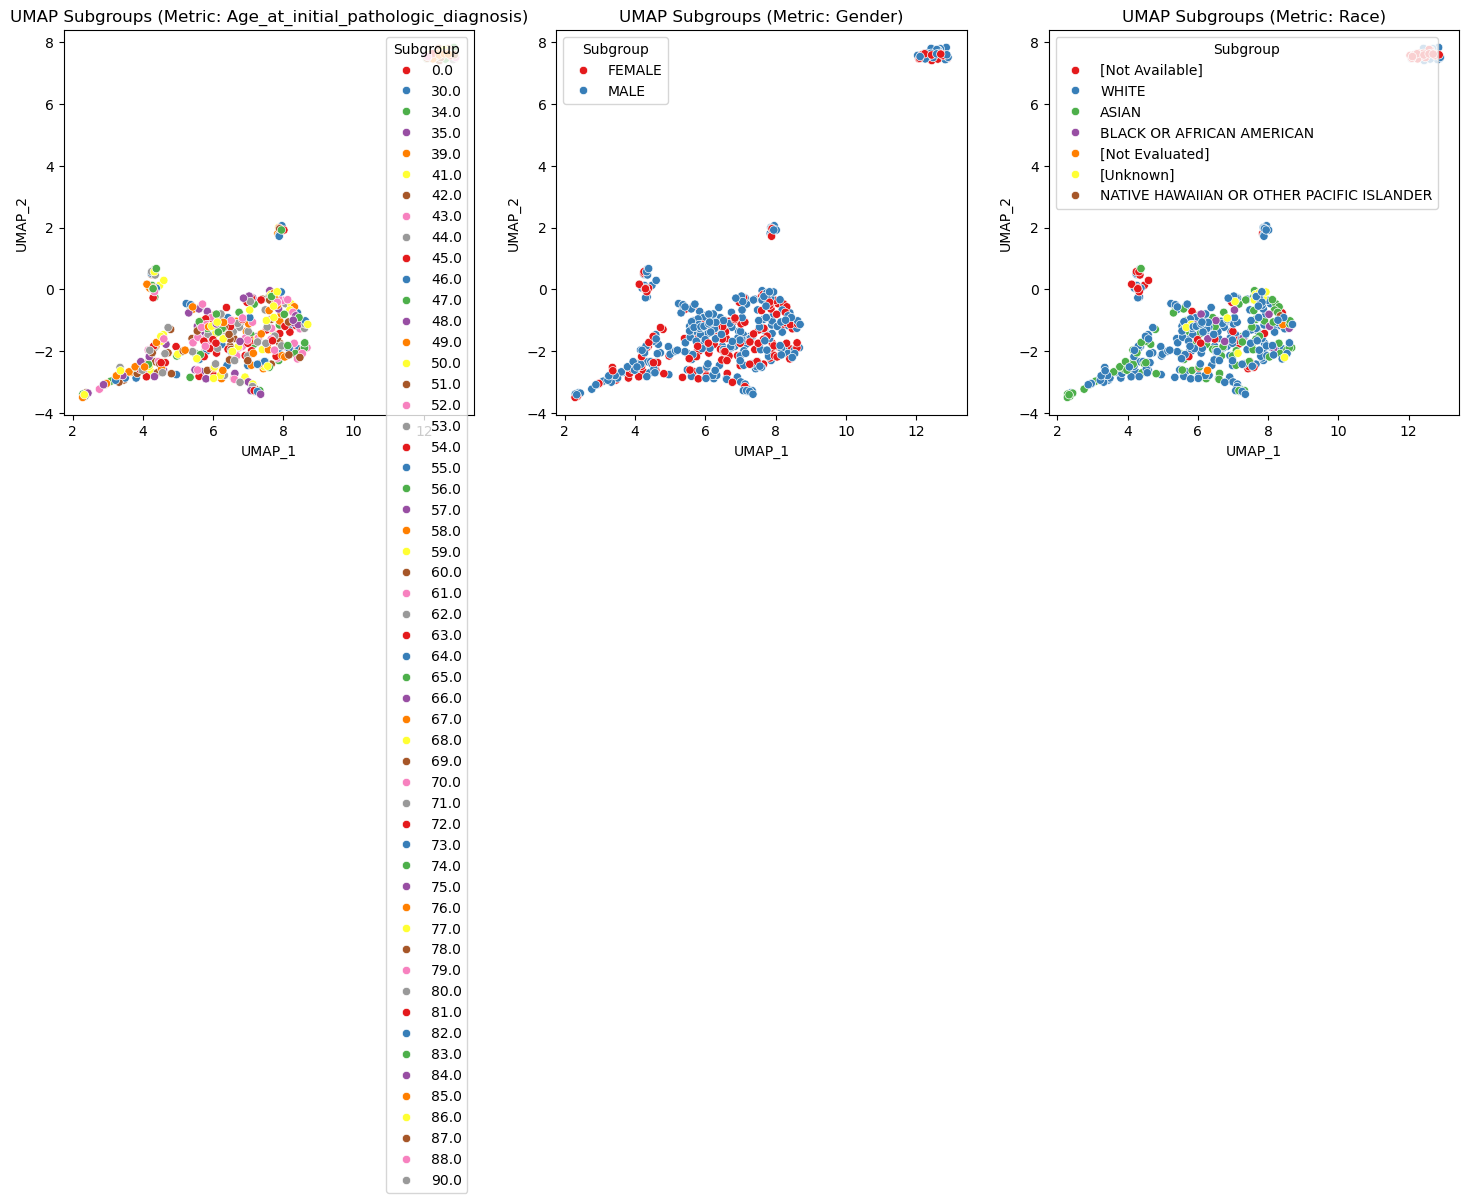

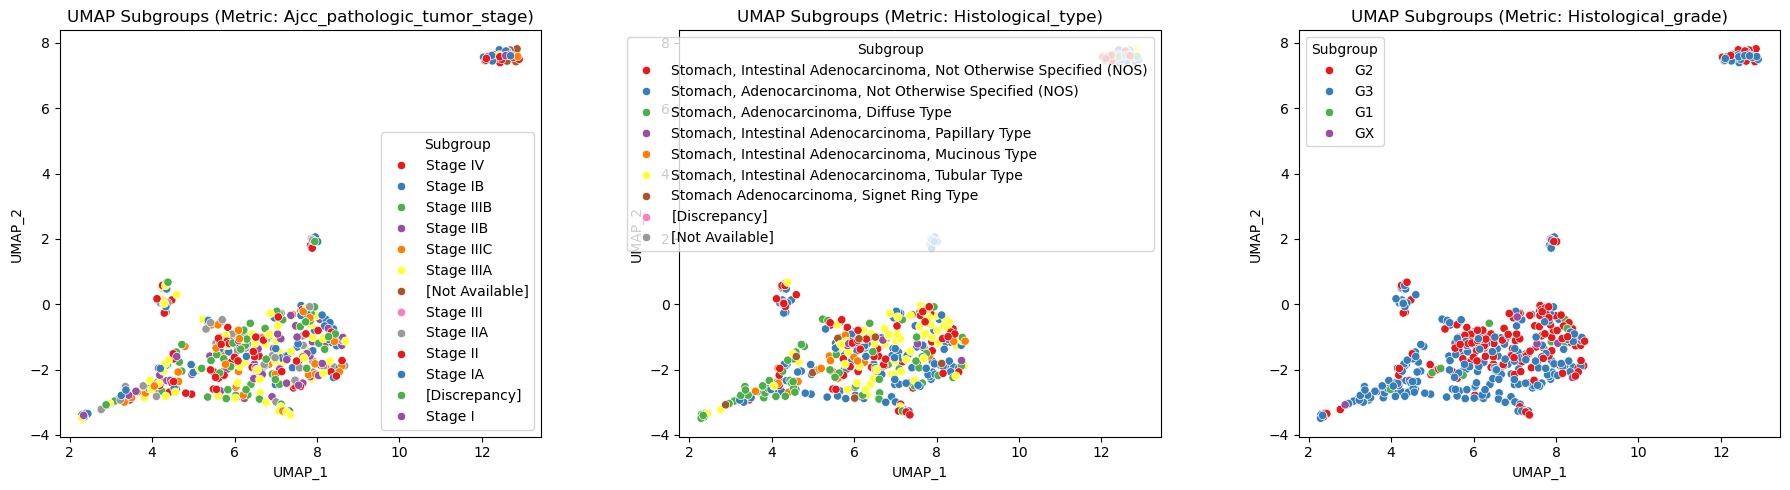

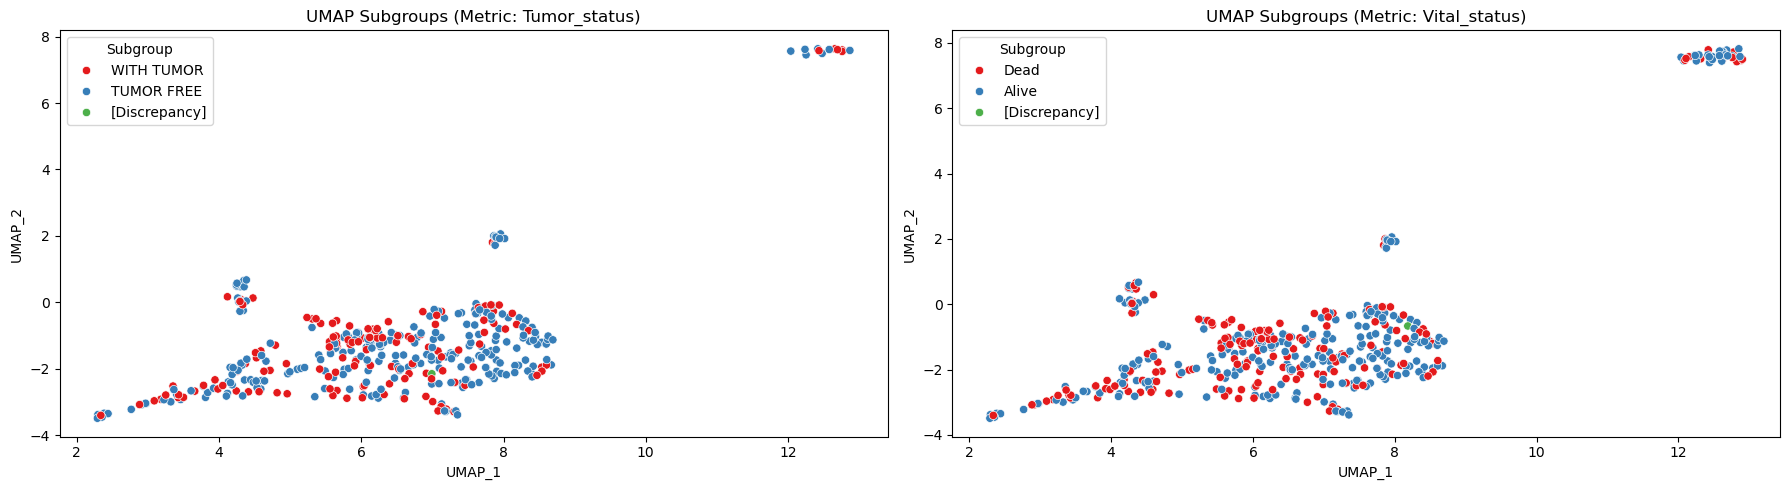

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['age_at_initial_pathologic_diagnosis', 'gender', 'race']):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['ajcc_pathologic_tumor_stage', 'histological_type','histological_grade']):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
for i, metric in enumerate(['tumor_status', 'vital_status']):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

# Genes enriched: select by large variance

In [89]:
results['patient_id'] = results.index

In [153]:
results.columns

Index(['PCA_1', 'PCA_2', 'MDS_1', 'MDS_2', 'TSNE_1', 'TSNE_2', 'UMAP_1',
       'UMAP_2', 'type', 'age_at_initial_pathologic_diagnosis', 'gender',
       'race', 'ajcc_pathologic_tumor_stage', 'histological_type',
       'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time',
       'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction',
       'PCA_2_cluster', 'PCA_3_cluster', 'PCA_4_cluster', 'PCA_5_cluster',
       'PCA_6_cluster', 'PCA_7_cluster', 'MDS_2_cluster', 'MDS_3_cluster',
       'MDS_4_cluster', 'MDS_5_cluster', 'MDS_6_cluster', 'MDS_7_cluster',
       'TSNE_2_cluster', 'TSNE_3_cluster', 'TSNE_4_cluster', 'TSNE_5_cluster',
       'TSNE_6_cluster', 'TSNE_7_cluster', 'UMAP_2_cluster', 'UMAP_3_cluster',
       'UMAP_4_cluster', 'UMAP_5_cluster', 'UMAP_6_cluster', 'UMAP_7_cluster',
       'Subgroup_euclidean', 'Subgroup_canberra', 'Subgroup_cosine',
       'patient_id'],
      dtype='object')

In [155]:
selected = ['tumor_status', 'race', 'gender', 'ajcc_pathologic_tumor_stage', 'histological_type', 'histological_grade']

dict_keys(['TUMOR FREE', 'WITH TUMOR', '[Discrepancy]'])


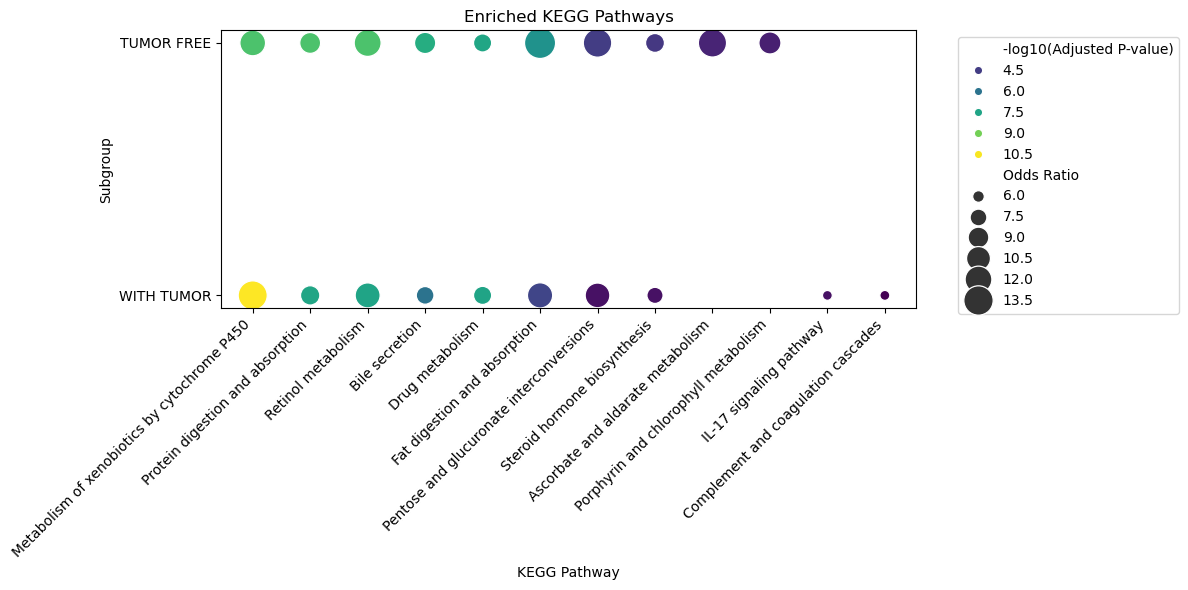

dict_keys(['ASIAN', 'BLACK OR AFRICAN AMERICAN', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'WHITE', '[Not Available]', '[Not Evaluated]', '[Unknown]'])


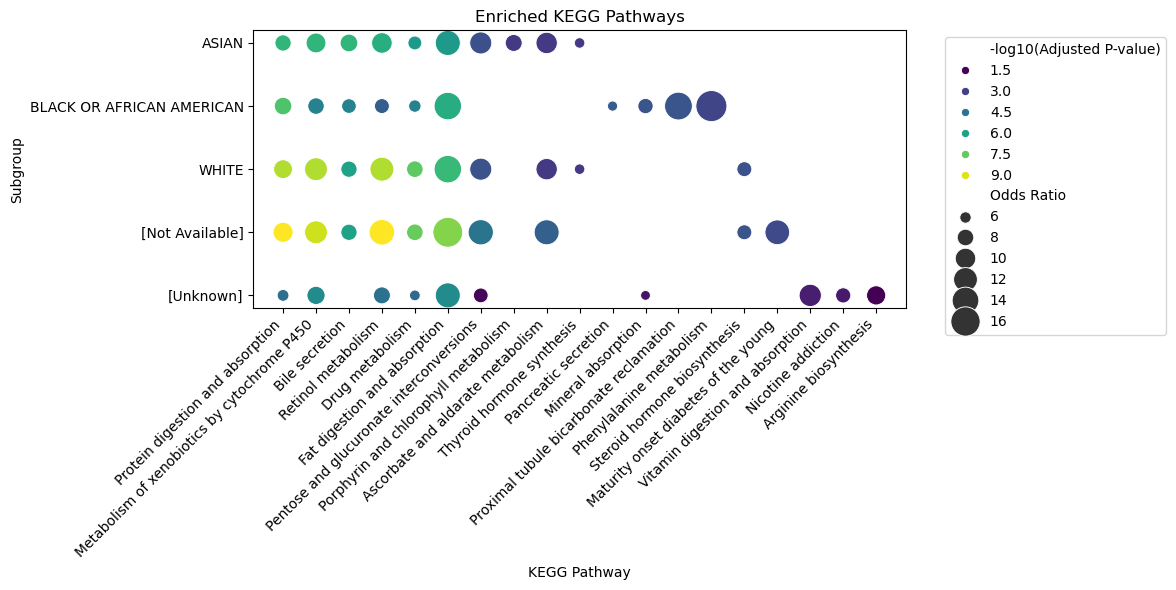

dict_keys(['FEMALE', 'MALE'])


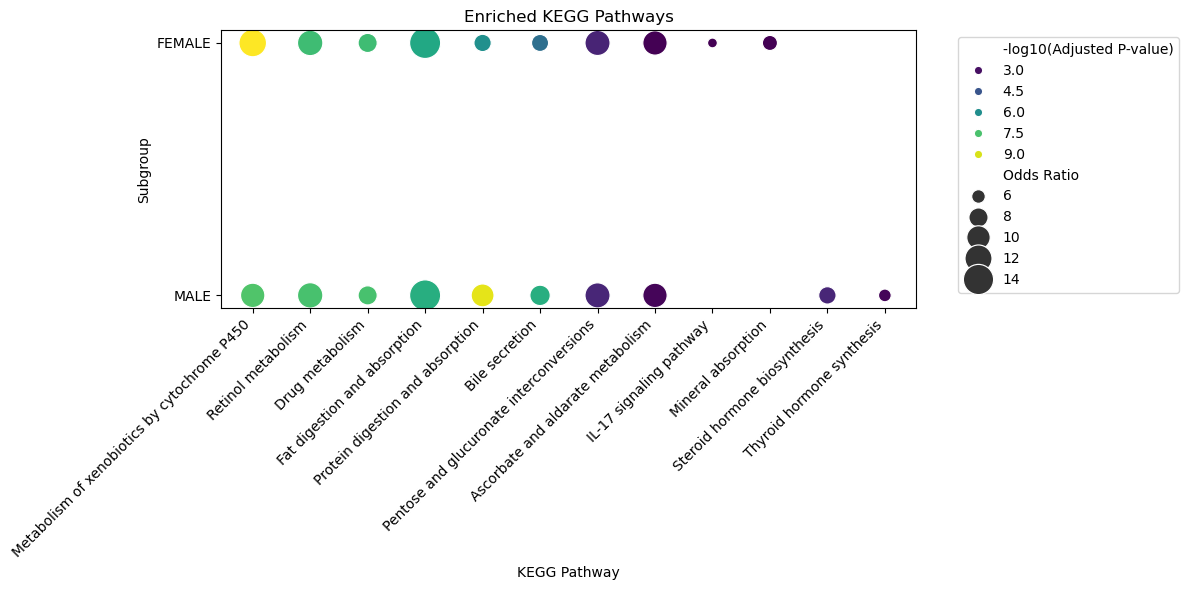

dict_keys(['Stage I', 'Stage IA', 'Stage IB', 'Stage II', 'Stage IIA', 'Stage IIB', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC', 'Stage IV', '[Discrepancy]', '[Not Available]'])


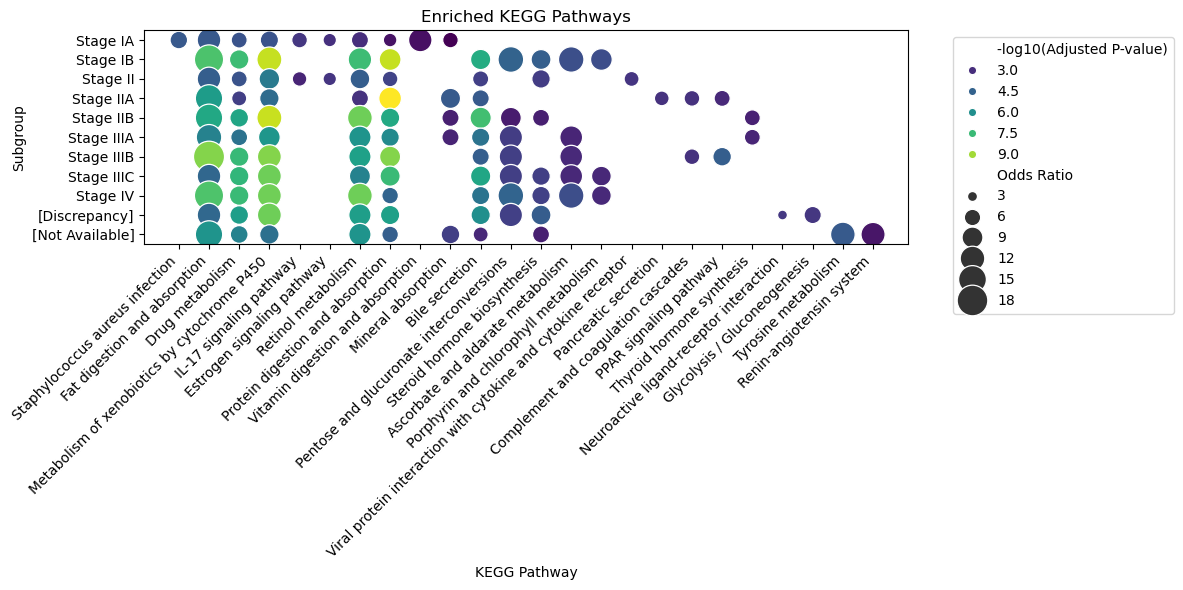

dict_keys(['Stomach Adenocarcinoma, Signet Ring Type', 'Stomach, Adenocarcinoma, Diffuse Type', 'Stomach, Adenocarcinoma, Not Otherwise Specified (NOS)', 'Stomach, Intestinal Adenocarcinoma, Mucinous Type', 'Stomach, Intestinal Adenocarcinoma, Not Otherwise Specified (NOS)', 'Stomach, Intestinal Adenocarcinoma, Papillary Type', 'Stomach, Intestinal Adenocarcinoma, Tubular Type', '[Discrepancy]', '[Not Available]'])


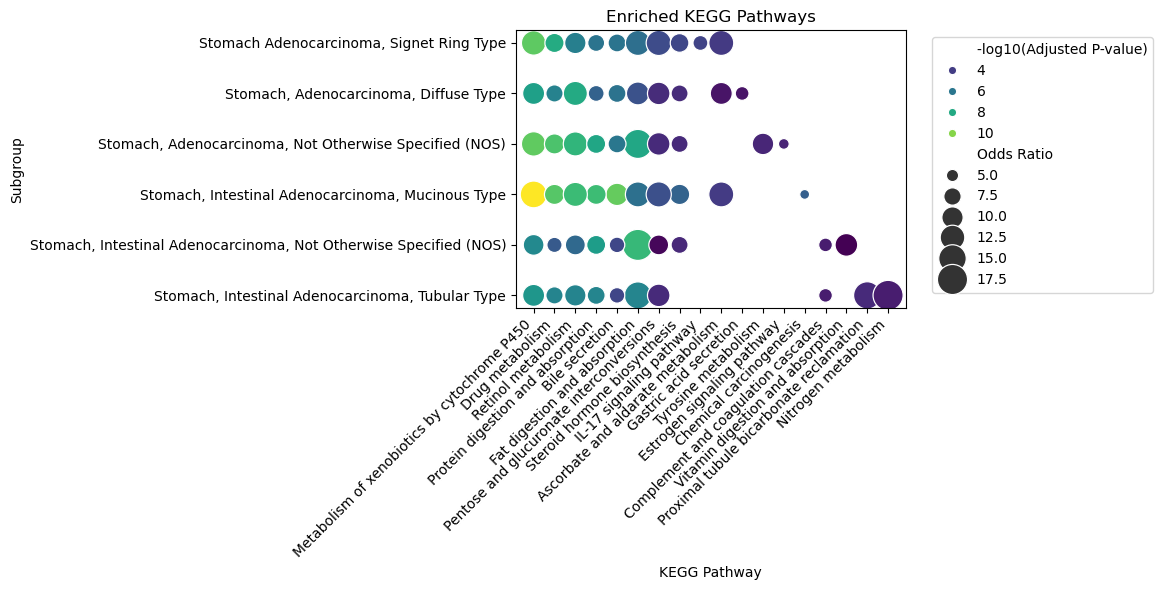

dict_keys(['G1', 'G2', 'G3', 'GX'])


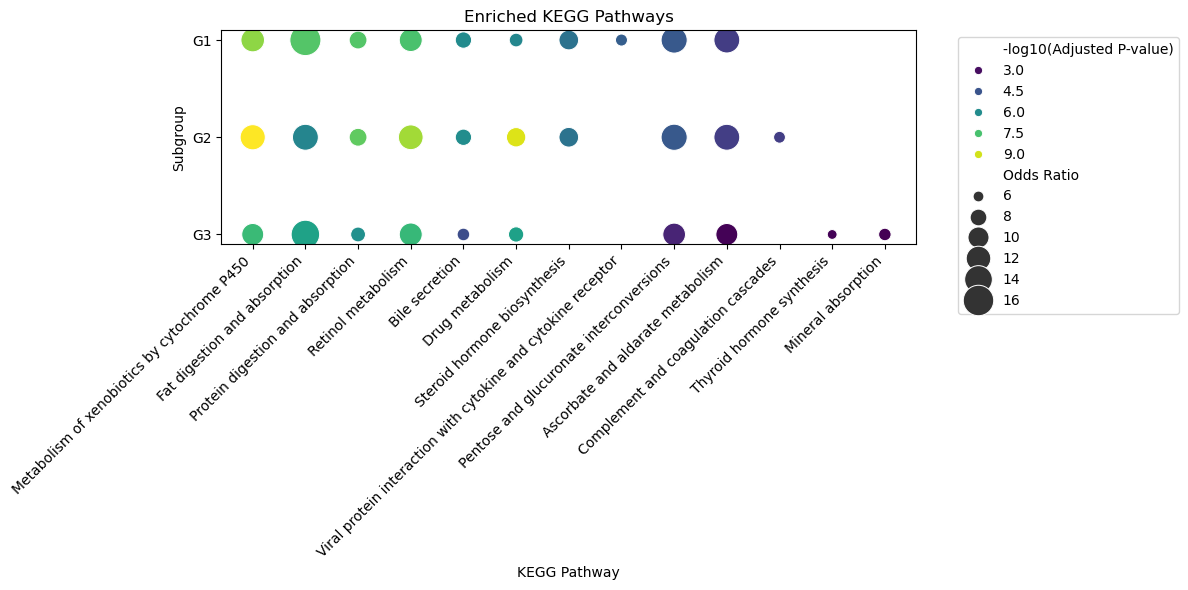

In [217]:
for column in selected:
    subgroup_dict = results.groupby(column)['patient_id'].agg(list).to_dict()
    print(subgroup_dict.keys())

    enrichr_results = {}

    for key in subgroup_dict.keys():
        if len(subgroup_dict[key]) < 10:
            continue
        expression_filtered_subset = expression_filtered[expression_filtered.index.isin(subgroup_dict[key])]
        gene_vars = expression_filtered_subset.var(axis=0)
        high_var_genes = gene_vars[gene_vars > gene_vars.quantile(0.95)]
        enriched_gene_list = [gene.split("|")[0] for gene in high_var_genes.index]
        enrichr_results[key] = enrichr(gene_list=enriched_gene_list, gene_sets='KEGG_2021_Human', outdir='enrichr_results')
        
    significant_pathways = {}
    pval_threshold = 0.05
    for key in enrichr_results.keys():
        results_df = enrichr_results[key].results
        significant_df = results_df[results_df['Adjusted P-value'] < pval_threshold]
        significant_df = significant_df.sort_values('Adjusted P-value').head(10)
        significant_df['-log10(Adjusted P-value)'] = -np.log10(significant_df['Adjusted P-value'])
        significant_pathways[key] = significant_df
    
    combined_df = []
    for key, df in significant_pathways.items():
        if not df.empty:
            df['Subgroup'] = key
            combined_df.append(df[['Subgroup', 'Term', 'Odds Ratio', '-log10(Adjusted P-value)']])

    if combined_df:
        combined_df = pd.concat(combined_df, ignore_index=True)
        plt.figure(figsize=(12, 6))
        sns.scatterplot(
            data=combined_df,
            x='Term',
            y='Subgroup',
            size='Odds Ratio',
            hue='-log10(Adjusted P-value)',
            palette='viridis',
            sizes=(50, 500)
        )
        plt.title('Enriched KEGG Pathways')
        plt.xlabel('KEGG Pathway')
        plt.ylabel('Subgroup')
        plt.xticks(rotation=45, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


# Take a look at Differential

In [218]:
subgroup_dict = results.groupby('race')['patient_id'].agg(list).to_dict()

In [219]:
subgroup_dict.keys()

dict_keys(['ASIAN', 'BLACK OR AFRICAN AMERICAN', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'WHITE', '[Not Available]', '[Not Evaluated]', '[Unknown]'])

In [220]:
expression_filtered = expression_filtered.loc[~expression_filtered.index.duplicated(keep='first')]

In [221]:
asian_expression = expression_filtered[expression_filtered.index.isin(subgroup_dict['ASIAN'])].T
white_expression = expression_filtered[expression_filtered.index.isin(subgroup_dict['WHITE'])].T
african_expression = expression_filtered[expression_filtered.index.isin(subgroup_dict['BLACK OR AFRICAN AMERICAN'])].T
native_expression = expression_filtered[expression_filtered.index.isin(subgroup_dict['NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'])].T

In [222]:
white_expression.to_csv('white_expression.csv')
asian_expression.to_csv('asian_expression.csv')
african_expression.to_csv('african_expression.csv')
native_expression.to_csv('native_expression.csv')

# Try the umap k=2 clusters

In [230]:
subgroup_dict = results.groupby('UMAP_2_cluster')['patient_id'].agg(list).to_dict()
expression_filtered = expression_filtered.loc[~expression_filtered.index.duplicated(keep='first')]

In [231]:
subgroup_dict.keys()

dict_keys([0, 1])

In [232]:
group1_expression = expression_filtered[expression_filtered.index.isin(subgroup_dict[0])].T
group2_expression = expression_filtered[expression_filtered.index.isin(subgroup_dict[1])].T
group1_expression.to_csv('group1_expression.csv')
group2_expression.to_csv('group2_expression.csv')